In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
!unzip /content/cars_images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_JQJ.jpg  
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_JxB.jpg  
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_KQU.jpg  
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_LBa.jpg  
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_lCR.jpg  
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_lVz.jpg  
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_NDU.jpg  
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_nUu.jpg  
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_Oak.jpg  
  inflating: cars_images/Porsche_718_2019_82_20_360_25_4_70_50_1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0/100, Step: 0, D Loss: 1.3954, G Loss: 0.7439, Time:14:54:25


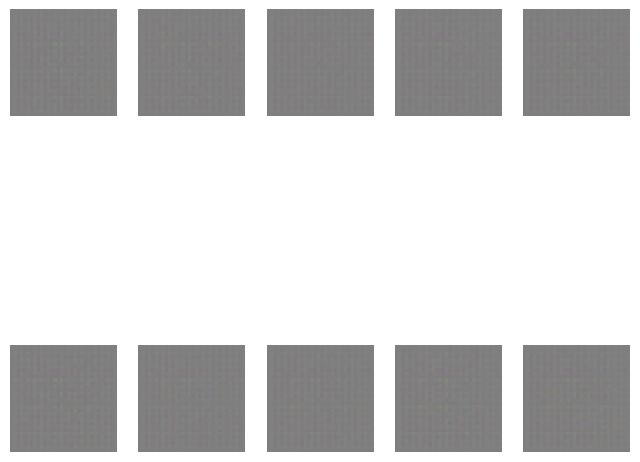

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3/100, Step: 500, D Loss: 0.8635, G Loss: 1.3056, Time:14:55:25


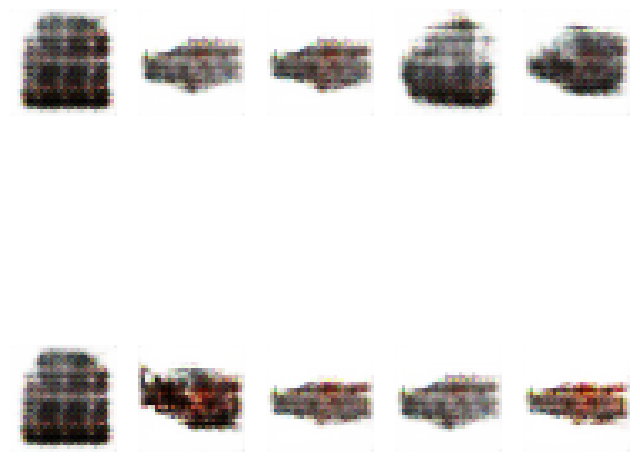

Epoch: 7/100, Step: 1000, D Loss: 0.5190, G Loss: 1.9695, Time:14:56:20


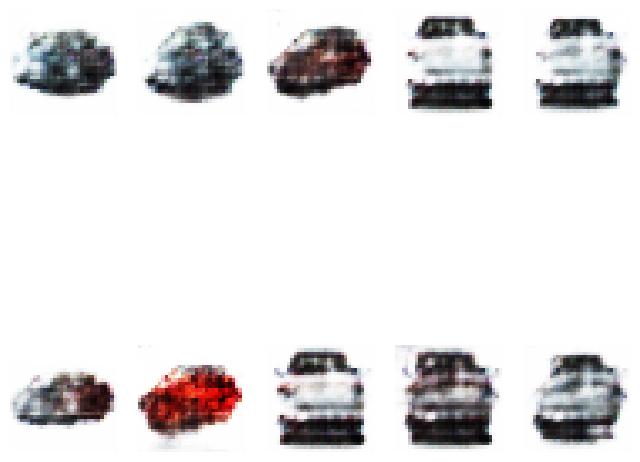

Epoch: 10/100, Step: 1500, D Loss: 0.8480, G Loss: 1.9734, Time:14:57:13


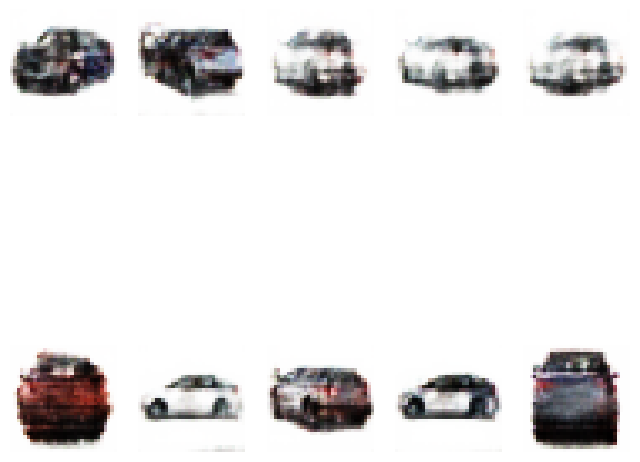

Epoch: 14/100, Step: 2000, D Loss: 0.8684, G Loss: 3.2688, Time:14:58:07


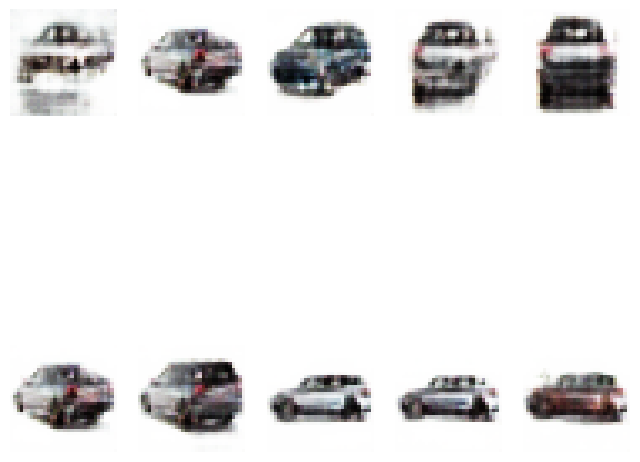

Epoch: 17/100, Step: 2500, D Loss: 0.8213, G Loss: 1.8207, Time:14:59:01


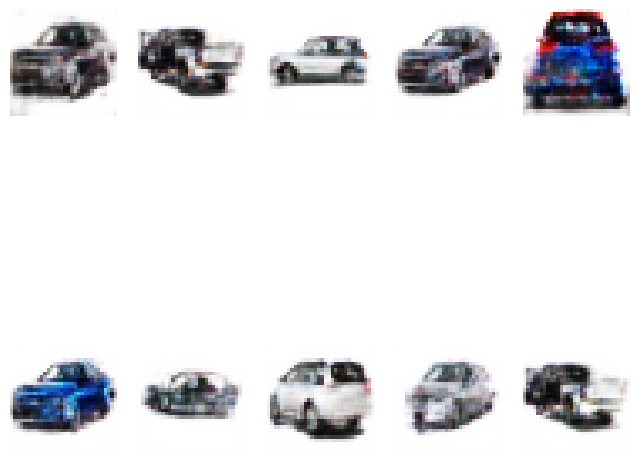

Epoch: 21/100, Step: 3000, D Loss: 0.3651, G Loss: 4.5053, Time:14:59:53


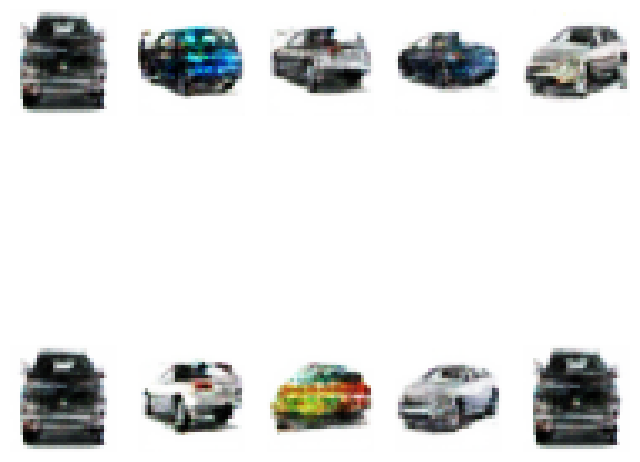

Epoch: 25/100, Step: 3500, D Loss: 0.2245, G Loss: 3.4442, Time:15:00:47


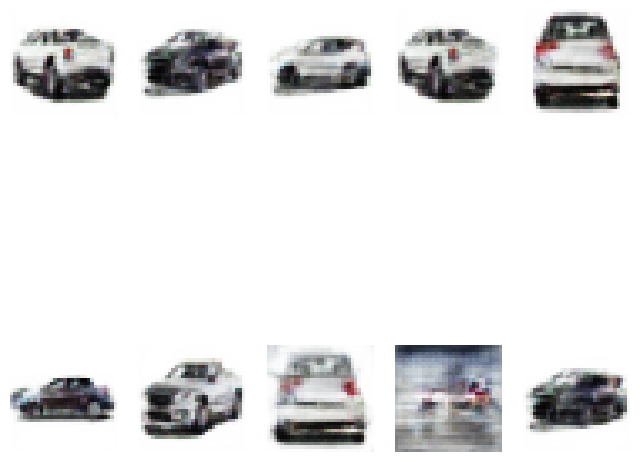

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import datetime
import os, sys
import glob
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow, imsave
%matplotlib inline
IMAGE_DIM = (32, 32, 3)

def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(device)
    y_hat = G(z).view(10, 3, 32, 32).permute(0, 2, 3, 1) # (100, 32, 32, 3)
    result = (y_hat.detach().cpu().numpy() + 1) / 2.
    return result



class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, out_channel=1, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, out_channel, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, self.init_dim[0], self.init_dim[1])
        y_ = self.conv(y_)
        return y_
class CARS(Dataset):
    '''
    CARS Dataset
    You should download this dataset from below url.
    url: https://ai.stanford.edu/~jkrause/cars/car_dataset.html
    '''
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.image_files = os.listdir(directory)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image


D = Discriminator(in_channel=IMAGE_DIM[-1]).to(device)
G = Generator(out_channel=IMAGE_DIM[-1]).to(device)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)
dataset = CARS(directory='/content/cars_images', transform=transform)
batch_size = 64
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))
max_epoch = 100
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100
D_labels = torch.ones([batch_size, 1]).to(device) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(device) # Discriminator Label to fake


for epoch in range(max_epoch):
    for idx, images in enumerate(data_loader):
        # Training Discriminator
        x = images.to(device)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(device)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(device)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise)
            plt.figure(figsize=(8, 8))
            for i in range(10):
                plt.subplot(2, 5, i+1)
                plt.imshow(img[i])
                plt.axis('off')
            plt.show()
            #plt.show(img)
            G.train()
        step += 1